## OSCAR JULIÁN PERDOMO CHARRY, PhD, ojperdomoc@unal.edu.co
## SISTEMAS EMBEBIDOS
## UNIVERSIDAD NACIONAL DE COLOMBIA

# Uso de Decision Trees and Random Forests para "HAR" usando acelerómetros!

# Consideraciones iniciales de la base de datos

*We will be analyzing the data with respect to all the subjects as we want to classify the activities in general and not be specific to the person.*

*The modelling for the data will be with respect to the sliding window functionality as the data samples are already sampled with 1 second window with 50% overlap.
This approach will take into consideration the pre-activities that will be involved in the actions being taken by the person as a sequence and will help in making better recurrent neural networks models.*

*'Working at Computer', 'Standing Up, Walking and Going up\\down stairs', 'Standing', 'Walking', 'Going Up\\Down Stairs', 'Walking and Talking with Someone', 'Talking while Standing'*



## Cargando y entendiendo los datos

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
#plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.ensemble as ske
import sklearn.tree as skt
import sklearn.preprocessing as skp
import random
import os, shutil, re, string
import spacy
seed=100

In [ ]:
from google.colab import drive
#drive.mount('/gdrive/')
# Si colocan algun archivo nuevo
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/Datos/"

 1_RedesNeuronales_I.ipynb
'Activity Recognition from Single Chest-Mounted Accelerometer'
 dataset_unico.csv


In [ ]:
# DEBEN COLOCAR SU PATH HACIA LA CARPETA QUE CONTIENE LOS DATOS
!ls '/content/gdrive/MyDrive/Datos'

 1_RedesNeuronales_I.ipynb
'Activity Recognition from Single Chest-Mounted Accelerometer'
 dataset_unico.csv


In [ ]:
# CARGANDO LOS DATOS DESDE GOOGLE-DRIVE
# scanning data and merging with participant as person column for identification
DIR = '/content/gdrive/MyDrive/Datos/'
df = pd.DataFrame()
df_temp = pd.read_csv(os.path.join(DIR,'dataset_unico.csv'))
df_temp.columns = ['ax_ms2','ay_ms2','az_ms2','gx_dps','gy_dps','gz_dps','gesture','person']
    # df_temp.drop('index', inplace=True, axis=1) # This line is commented out as 'index' column might not exist
#     df_temp.drop(df_temp[df_temp['class'] == 0].index.tolist(), inplace=True, axis=0)
df = pd.concat([df, df_temp], axis=0)

df = df.reset_index(drop=True)
print("Scanned",len(df.person.unique()),"participants recordings")
df.tail()

Scanned 6 participants recordings


,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,gesture,person
22545,2.04,5.18,8.48,0.02,4.41,0.93,yessr,3.00
22546,1.94,4.86,8.41,0.53,3.37,4.30,yessr,3.00
22547,1.68,4.81,8.49,1.13,2.67,2.25,yessr,3.00
22548,1.68,5.00,8.27,-0.24,-0.19,3.95,yessr,3.00
22549,1.58,4.74,8.01,-0.44,2.99,1.24,yessr,3.00


In [ ]:
!ls '/content/gdrive/MyDrive/Datos/'

 1_RedesNeuronales_I.ipynb
'Activity Recognition from Single Chest-Mounted Accelerometer'
 dataset_unico.csv


In [ ]:
df.shape

(22550, 8)

In [ ]:
df.head()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,gesture,person
0,-0.16,-0.17,9.94,-1.23,3.94,0.50,nada,2.00
1,-0.02,-0.14,9.79,-1.91,4.39,0.85,nada,2.00
2,-0.10,-0.20,9.84,-1.97,4.82,0.69,nada,2.00
3,-0.05,-0.19,9.82,-1.53,4.88,0.82,nada,2.00
4,-0.06,-0.26,9.82,-1.11,5.58,0.18,nada,2.00


In [ ]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/Datos/dataset_unico.csv')
#df = pd.read_csv('/content/dataset_acc.csv')
df.shape

(22550, 8)

In [ ]:
df.head()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,gesture,person
0,-0.16,-0.17,9.94,-1.23,3.94,0.50,nada,2.00
1,-0.02,-0.14,9.79,-1.91,4.39,0.85,nada,2.00
2,-0.10,-0.20,9.84,-1.97,4.82,0.69,nada,2.00
3,-0.05,-0.19,9.82,-1.53,4.88,0.82,nada,2.00
4,-0.06,-0.26,9.82,-1.11,5.58,0.18,nada,2.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22550 entries, 0 to 22549
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ax_ms2   22550 non-null  float64
 1   ay_ms2   22550 non-null  float64
 2   az_ms2   22550 non-null  float64
 3   gx_dps   22550 non-null  float64
 4   gy_dps   22550 non-null  float64
 5   gz_dps   22550 non-null  float64
 6   gesture  21538 non-null  object 
 7   person   21538 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.4+ MB


In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [ ]:
df.head()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,gesture,person
0,-0.16,-0.17,9.94,-1.23,3.94,0.50,nada,2.00
1,-0.02,-0.14,9.79,-1.91,4.39,0.85,nada,2.00
2,-0.10,-0.20,9.84,-1.97,4.82,0.69,nada,2.00
3,-0.05,-0.19,9.82,-1.53,4.88,0.82,nada,2.00
4,-0.06,-0.26,9.82,-1.11,5.58,0.18,nada,2.00


In [ ]:
#df.to_csv('dataset_acc.csv')

In [ ]:
# map index to label
index_label = dict()
index_label[0] = "like"
index_label[1] = "nada"
index_label[2] = "spider"
index_label[3] = "presente"
index_label[4] = "dislike"

index_label.values()

dict_values(['like', 'nada', 'spider', 'presente', 'dislike'])

## Visualización de Datos Inicial

In [ ]:
df.tail()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,gesture,person
22545,2.04,5.18,8.48,0.02,4.41,0.93,yessr,3.00
22546,1.94,4.86,8.41,0.53,3.37,4.30,yessr,3.00
22547,1.68,4.81,8.49,1.13,2.67,2.25,yessr,3.00
22548,1.68,5.00,8.27,-0.24,-0.19,3.95,yessr,3.00
22549,1.58,4.74,8.01,-0.44,2.99,1.24,yessr,3.00


In [ ]:
df['gesture'].value_counts().reset_index()

,gesture,count
0,nada,3737
1,like,3656
2,dislike,3560
3,presente,3538
4,spider,3534
5,yessr,3513


In [ ]:
df[df['person']==1]

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,gesture,person
214,0.38,6.49,7.40,-0.25,4.72,0.76,like,1.00
215,0.62,6.46,7.17,-4.68,2.74,3.66,like,1.00
216,0.65,6.43,7.12,5.11,5.04,1.26,like,1.00
217,0.65,6.42,7.29,-1.69,8.19,1.56,like,1.00
218,0.58,6.41,7.20,-2.22,6.50,1.66,like,1.00
...,...,...,...,...,...,...,...,...
21580,3.69,-3.30,6.66,27.21,-26.87,-38.95,yessr,1.00
21581,4.64,-2.58,6.69,23.39,-43.79,-50.14,yessr,1.00
21582,4.17,-2.03,6.52,29.11,-47.98,-64.05,yessr,1.00
21583,5.52,-1.67,6.27,26.53,-64.07,-81.18,yessr,1.00


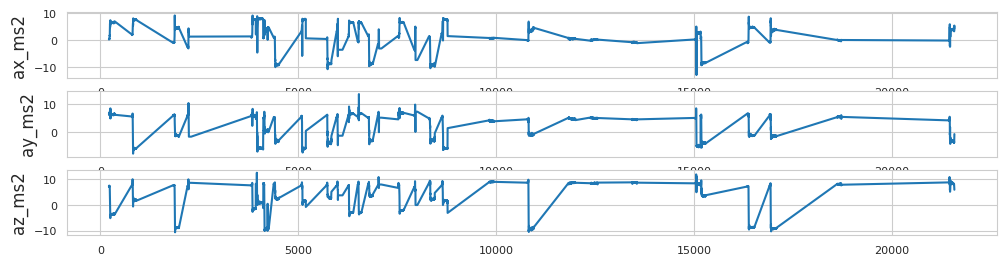

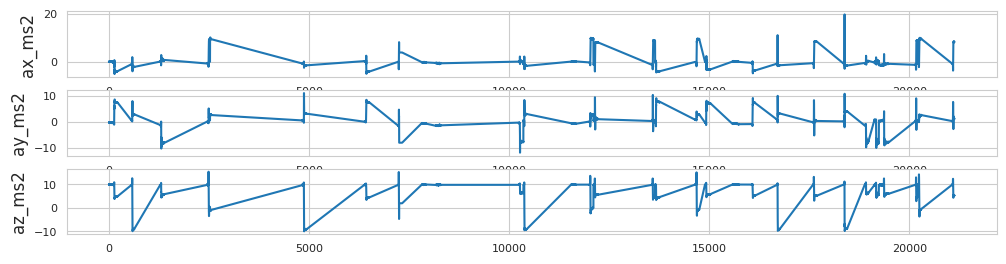

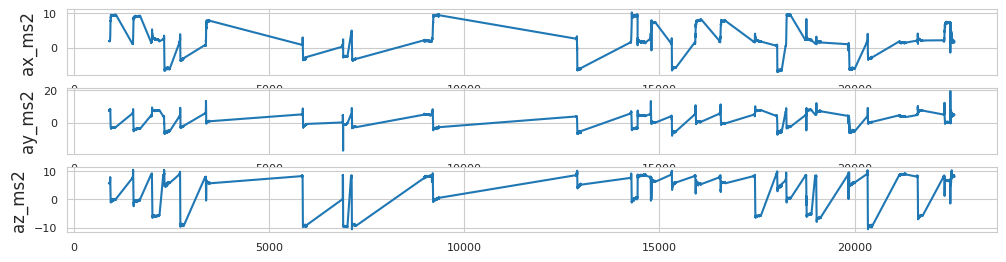

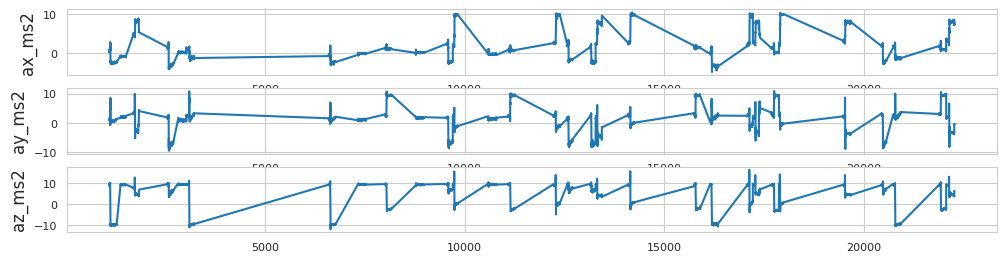

In [ ]:
# plot x, y, z acceleration
def plotXYZ(df_plot, p):
    plt.figure()
    for col in range(3):
        plt.subplot(df_plot.shape[1], 1, col+1)
        sns.lineplot(data=df_plot,x=np.array(df_plot.index.tolist()), y=df_plot.iloc[:,col])
    plt.show()

for x in range(1,5):
    df_temp = df[df["person"]==x]
    plotXYZ(df_temp, x)

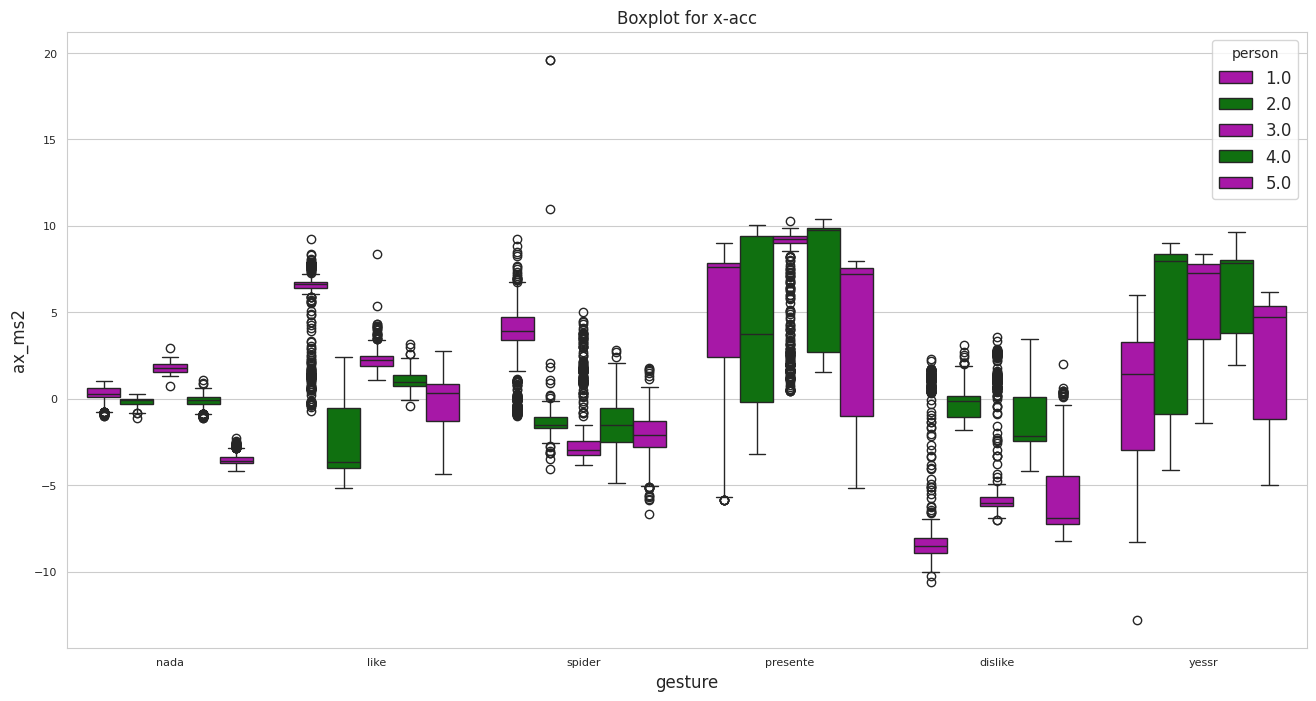

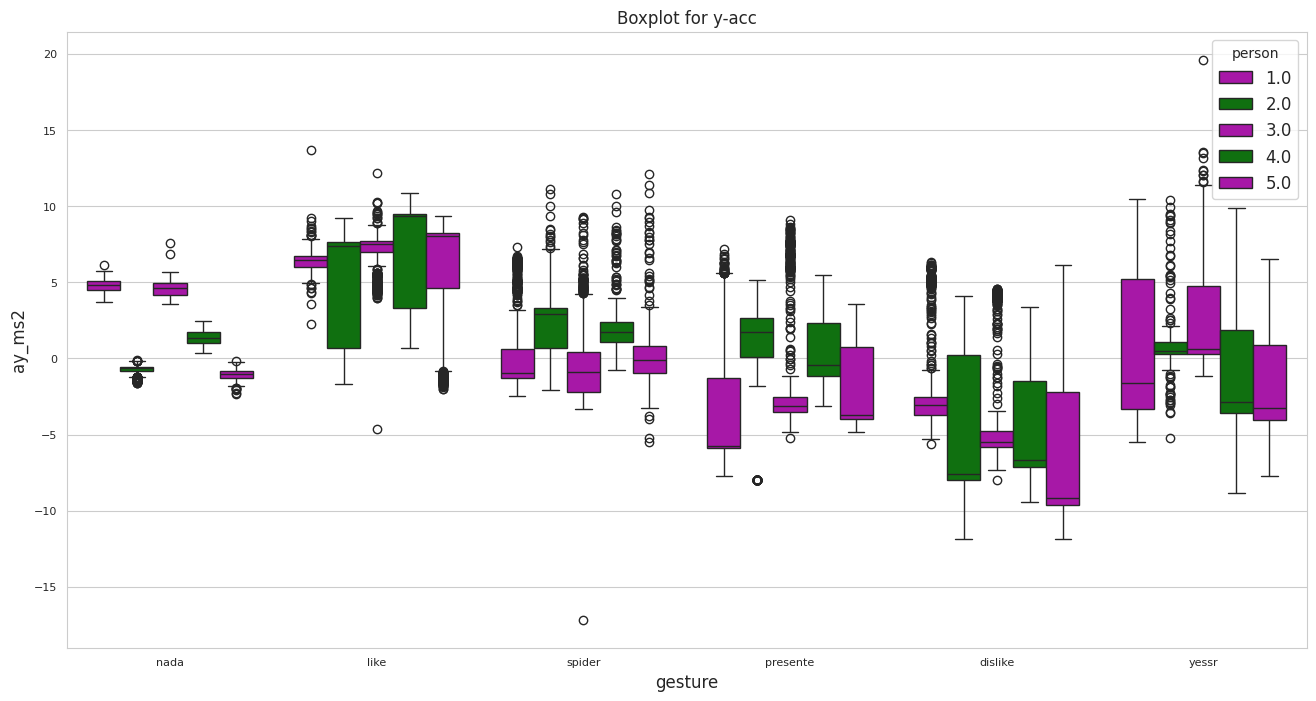

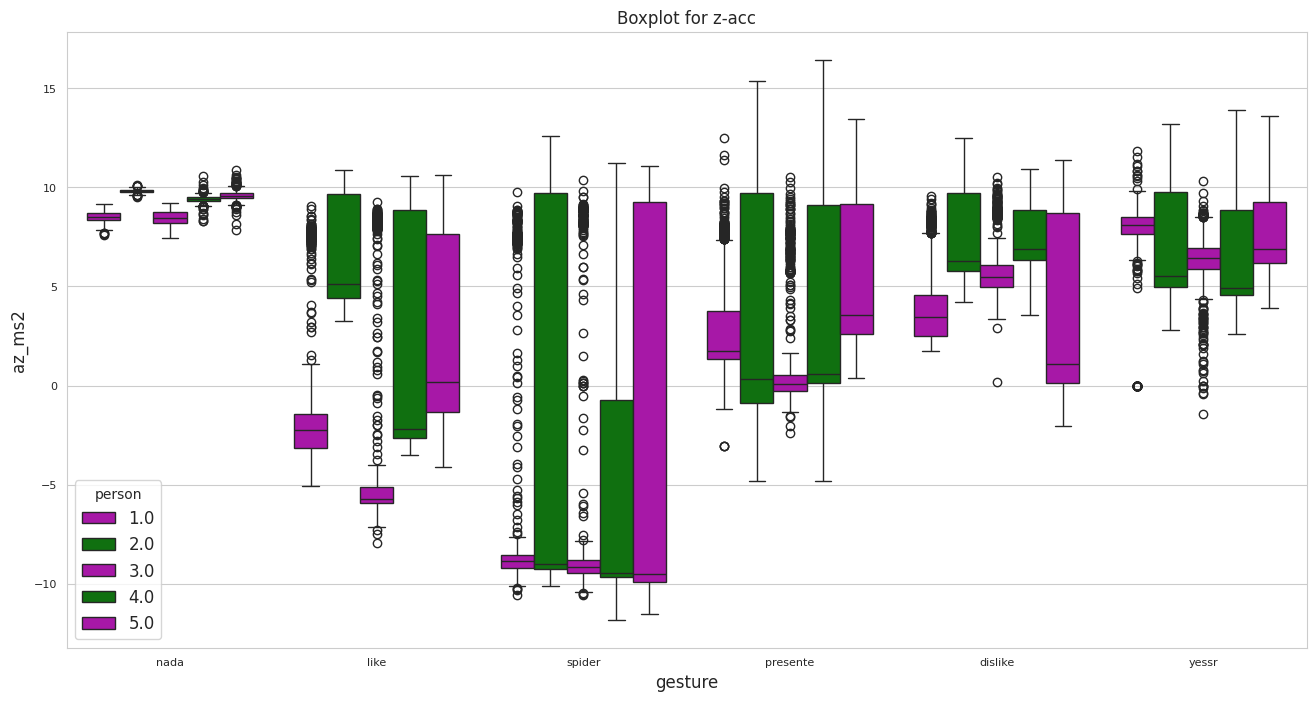

In [ ]:
# plot boxplot for all classes
plt.figure(figsize=(16,8))
sns.boxplot(x="gesture", y="ax_ms2",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for x-acc")
plt.show()


plt.figure(figsize=(16,8))
sns.boxplot(x="gesture", y="ay_ms2",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for y-acc")
plt.show()


plt.figure(figsize=(16,8))
sns.boxplot(x="gesture", y="az_ms2",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for z-acc")
plt.show()


There are outliers present in the data. Class 1 has most number of outliers present in it and need to be treated.

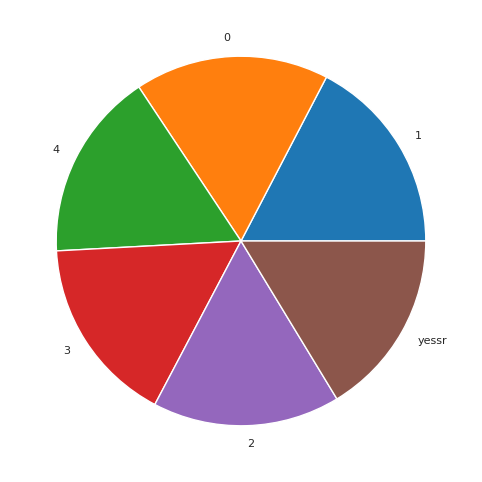

In [ ]:
# checking distribution of samples against classes
plt.figure(figsize=(12,6))
plt.pie(df['gesture'].value_counts(), labels=[index_label[x] for x in df['gesture'].value_counts().index])
plt.show()

*   index_label[1] = "Working at Computer",
*   index_label[3] = "Standing",
*   index_label[4] = "Walking",
*   index_label[7] = "Talking while Standing"

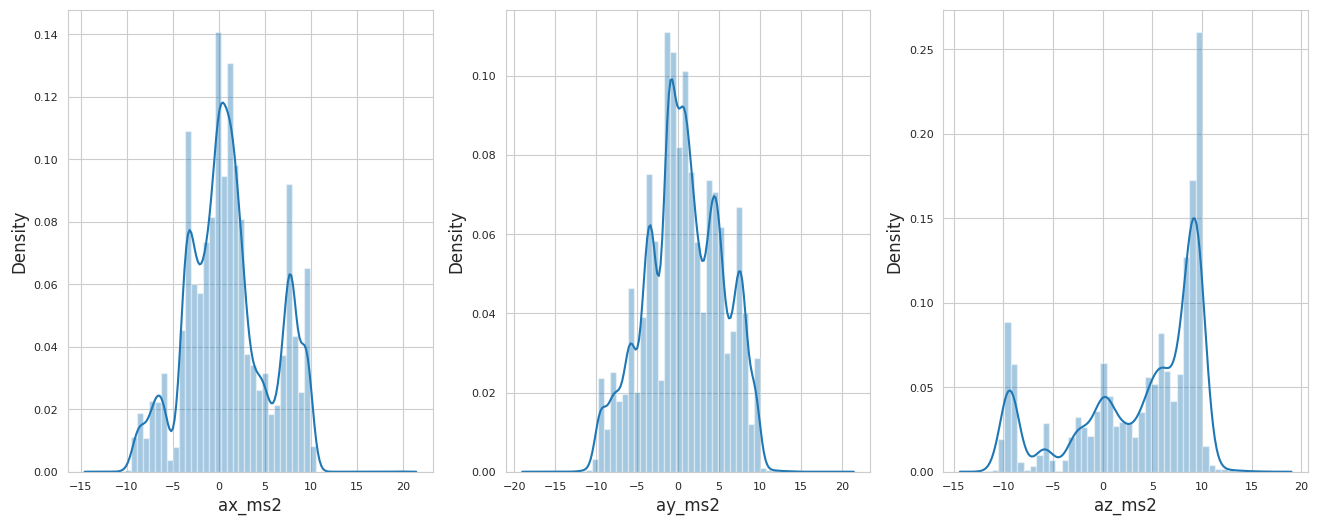

In [ ]:
# checking distributions for x, y and z
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.distplot(df['ax_ms2'])

plt.subplot(1,3,2)
sns.distplot(df['ay_ms2'])

plt.subplot(1,3,3)
sns.distplot(df['az_ms2'])
plt.show()

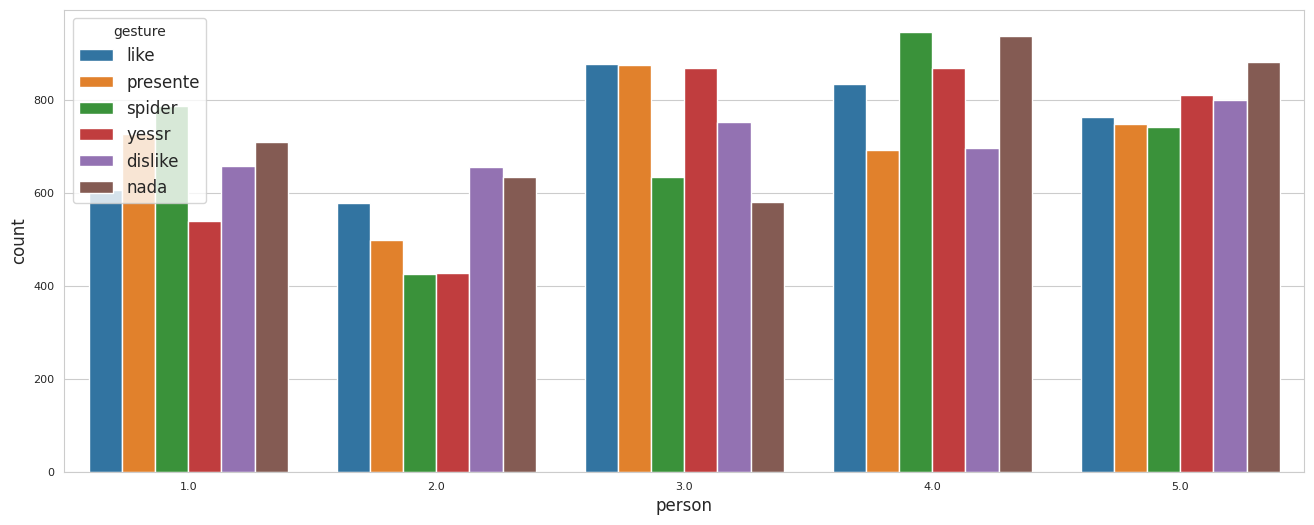

In [ ]:
# countplot distribution for each person per class
plt.figure(figsize=(16,6))
sns.countplot(x='person', hue='gesture', data=df)
plt.show()

## **Como conclusión encontramos que las clases estan altamente imbalanceadas y necesitan ser analizadas con cuidado!!!**

# Data Preparation

In [ ]:
# remove multi-activities classes - 0, 2, and 6
df = df[~df[""].isin([0,2,5,6,3])]
print("Remaining classes",df['class'].unique())

KeyError: ''

In [ ]:
# replacing class 0, and 2 with 5 and 7 respectively.
# 0 => 5
# 2 => 7
df['class'] = [2 if x is 7 else x for x in df['class']]
df['class'] = [3 if x is 4 else x for x in df['class']]
df['class'].value_counts().reset_index()

,class,count
0,1,608652
1,2,593563
2,3,357064


In [ ]:
# removing outliers, values away from mean +- x*sd, from all classes for x, y and z
indexesToRemove = []
for x in df['gesture'].unique().tolist():
    # filter with specific class
    print("Filtering class",x)
    df_temp = df[df['gesture'] == x]

    for y in range(3):
        # remove rows with values away from mean by 3SD, in x, y and z
        mean = df_temp.iloc[:,y].mean()
        sd = df_temp.iloc[:,y].std()
        away = 1.5
        upperlimit = mean + away * sd
        lowerlimit = mean - away * sd

        i = df_temp[(df_temp.iloc[:,y] > upperlimit) | (df_temp.iloc[:,y] < lowerlimit)].index.tolist()
        indexesToRemove.extend(i)

indexesToRemove = list(set(indexesToRemove))
df.drop(indexesToRemove, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Removed",len(indexesToRemove),"rows.")

Filtering class nada
Filtering class like
Filtering class spider
Filtering class presente
Filtering class dislike
Filtering class yessr
Filtering class nan
Removed 6427 rows.


In [ ]:
# checking distribution of x, y and z after removing outliers
df.describe()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,person
count,14234.00,14234.00,14234.00,14234.00,14234.00,14234.00,13222.00
mean,1.65,0.16,2.87,-0.25,2.67,2.21,3.30
std,4.84,4.69,6.19,23.05,16.74,15.78,1.28
min,-9.31,-10.30,-11.81,-250.14,-245.86,-128.21,1.00
25%,-1.32,-3.47,-0.53,-2.37,1.12,-0.56,2.00
50%,0.92,-0.13,4.88,-0.92,4.11,0.32,3.00
75%,6.31,3.66,8.52,0.67,5.43,1.21,4.00
max,10.42,10.73,10.67,250.13,195.54,250.13,5.00


## Creando los conjuntos de Entrenamiento y Prueba

In [ ]:
# splitting by person recordings, first 12 for training and last 3 for test
X_train = df[df['person'] <= 3]
X_test = df[df['person'] > 3]
y_train = X_train.pop('gesture')
y_test = X_test.pop('gesture')
X_train.head()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,person
0,-0.16,-0.17,9.94,-1.23,3.94,0.50,2.00
1,-0.02,-0.14,9.79,-1.91,4.39,0.85,2.00
2,-0.10,-0.20,9.84,-1.97,4.82,0.69,2.00
3,-0.05,-0.19,9.82,-1.53,4.88,0.82,2.00
4,-0.06,-0.26,9.82,-1.11,5.58,0.18,2.00


In [ ]:
# drop person column from both
X_train.drop('person', axis=1, inplace=True)
X_test.drop('person', axis=1, inplace=True)
X_train.head()

,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps
0,-0.16,-0.17,9.94,-1.23,3.94,0.50
1,-0.02,-0.14,9.79,-1.91,4.39,0.85
2,-0.10,-0.20,9.84,-1.97,4.82,0.69
3,-0.05,-0.19,9.82,-1.53,4.88,0.82
4,-0.06,-0.26,9.82,-1.11,5.58,0.18


In [ ]:
y_train.sample(10)

,gesture
846,presente
3271,presente
12597,presente
5193,presente
10023,yessr
7483,nada
11815,like
4062,spider
7413,nada
689,dislike


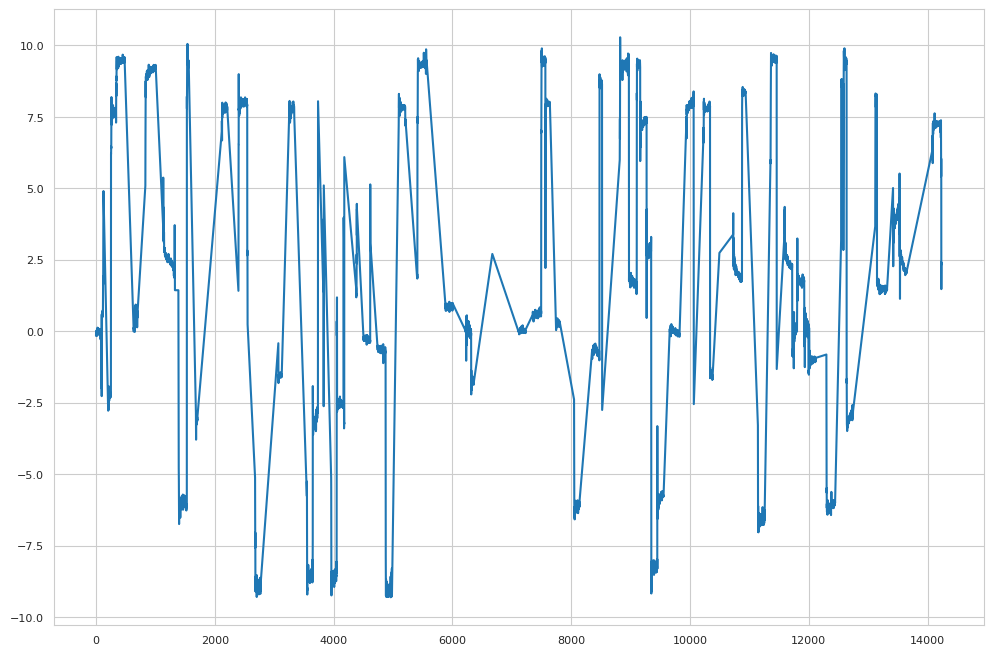

In [ ]:
plt.plot(X_train['ax_ms2'][0:10000])

In [ ]:
X_train['ax_ms2'].max()

10.283

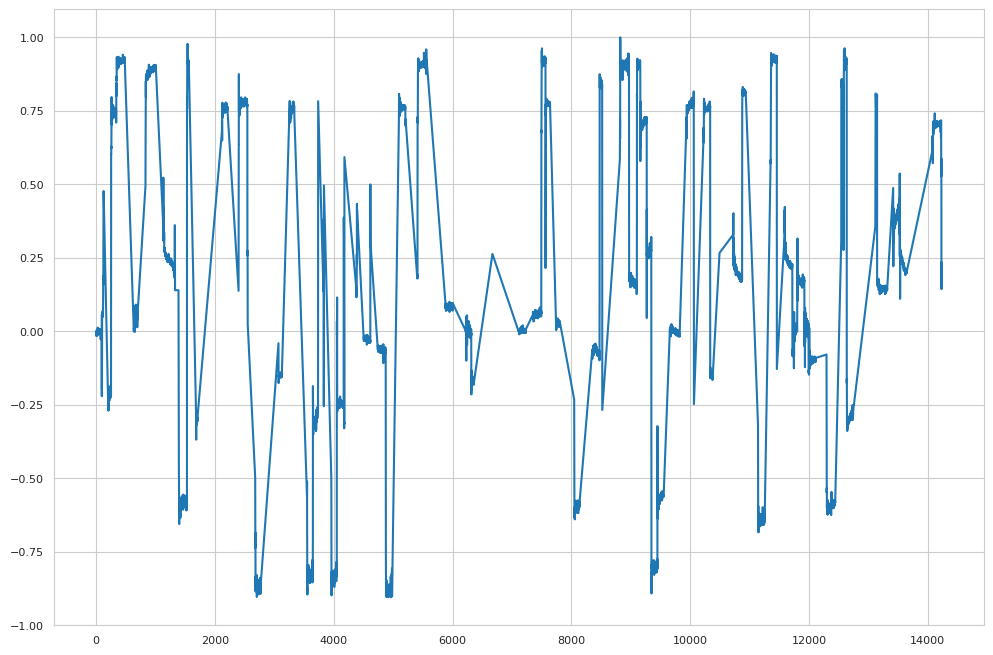

In [ ]:
plt.plot(X_train['ax_ms2'][0:10000]/X_train['ax_ms2'].max())

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((6742, 6), (6742,), (6480, 6), (6480,))

## Colocando pesos para mitigar el "Class Imbalance"

In [ ]:
# generate training class weights which will be fed into model while training
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
train_class_weights = dict(zip(np.unique(y_train), weights))
pprint(train_class_weights)

{'dislike': np.float64(0.7296536796536797),
 'like': np.float64(1.4424475823705605),
 'nada': np.float64(0.8083932853717026),
 'presente': np.float64(0.8142512077294686),
 'spider': np.float64(2.050486618004866),
 'yessr': np.float64(1.016892911010558)}


## Escalando los Datos

In [ ]:
scaler = skp.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

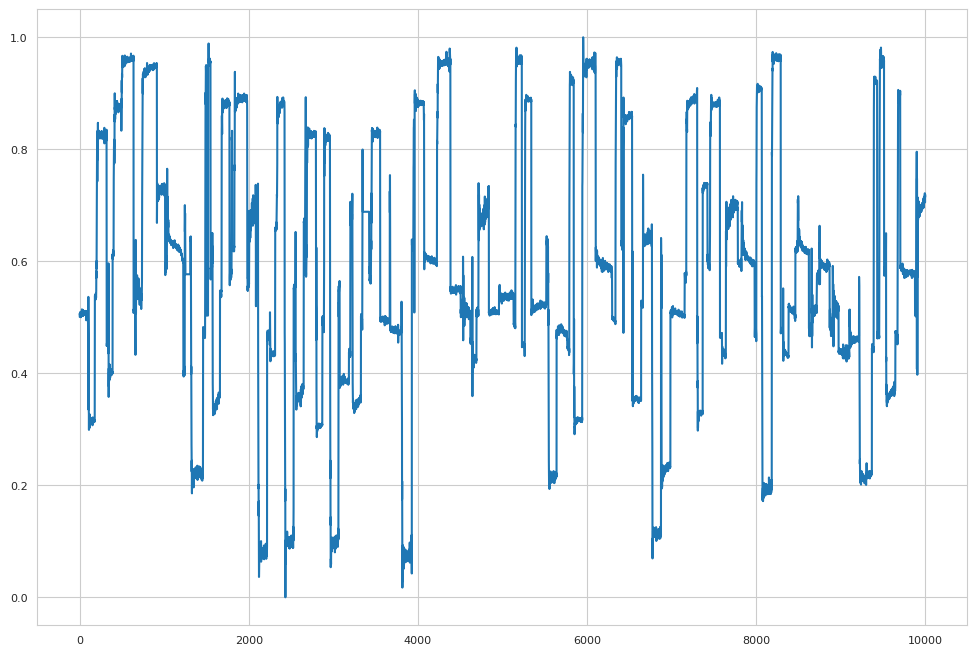

In [ ]:
plt.plot(X_train['ax_ms2'][0:10000])

## Decision Tree Model

In [ ]:
dtc = skt.DecisionTreeClassifier(max_depth=8, random_state=seed, class_weight=train_class_weights)
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
skm.accuracy_score(y_test, predictions)

0.9628086419753087

In [ ]:
from sklearn.metrics import confusion_matrix
predictions_tr = dtc.predict(X_train)
confusion_matrix(y_train, predictions_tr)

array([[1480,    0,   60,    0,    0,    0],
       [   0,  779,    0,    0,    0,    0],
       [   0,    0, 1390,    0,    0,    0],
       [   0,    0,    0, 1380,    0,    0],
       [   0,    0,    0,    0,  548,    0],
       [   0,    0,    0,    0,    0, 1105]])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 887,    5,   15,    0,    0,    0],
       [   1, 1172,    0,    0,    0,    0],
       [ 143,    0,  930,    0,    0,    0],
       [   0,   26,    0,  914,    0,   21],
       [   0,    1,    0,    0, 1118,    1],
       [   6,    0,   10,   12,    0, 1218]])

In [ ]:
#import pickle
import joblib
filename = 'DT_3.sav'
#pickle.dump(dtc, open(filename, 'wb'))
joblib.dump(dtc, filename)

['DT_3.sav']

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

NameError: name 'pickle' is not defined

## Random Forest Model

In [ ]:
rfc = ske.RandomForestClassifier(n_estimators=5, random_state=seed, class_weight=train_class_weights)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
skm.accuracy_score(y_test, predictions)

0.8692901234567901

In [ ]:
from sklearn.metrics import confusion_matrix
predictions_tr = rfc.predict(X_train)
confusion_matrix(y_train, predictions_tr)

array([[1539,    0,    1,    0,    0,    0],
       [   0,  779,    0,    0,    0,    0],
       [   2,    0, 1388,    0,    0,    0],
       [   0,    0,    0, 1380,    0,    0],
       [   0,    0,    0,    0,  548,    0],
       [   1,    0,    0,    0,    0, 1104]])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 901,    0,    4,    0,    0,    2],
       [   2, 1171,    0,    0,    0,    0],
       [ 726,    0,  347,    0,    0,    0],
       [   0,    0,    0,  936,    0,   25],
       [   1,    0,    0,    3, 1116,    0],
       [   5,    0,   40,   39,    0, 1162]])

In [ ]:
#import pickle
import joblib
filename = 'RF_3.sav'
#pickle.dump(rfc, open(filename, 'wb'))
joblib.dump(rfc, filename)

['RF_3.sav']

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.5675898280654793

In [ ]:
!pip list -v

Package                                  Version             Location                                Installer
---------------------------------------- ------------------- --------------------------------------- ---------
absl-py                                  1.4.0               /usr/local/lib/python3.12/dist-packages uv
absolufy-imports                         0.3.1               /usr/local/lib/python3.12/dist-packages uv
accelerate                               1.11.0              /usr/local/lib/python3.12/dist-packages uv
aiofiles                                 24.1.0              /usr/local/lib/python3.12/dist-packages uv
aiohappyeyeballs                         2.6.1               /usr/local/lib/python3.12/dist-packages uv
aiohttp                                  3.13.1              /usr/local/lib/python3.12/dist-packages uv
aiosignal                                1.4.0               /usr/local/lib/python3.12/dist-packages uv
alabaster                                1.0.0    

## **Hacer un Pipeline para dejar todo en un solo paso!**
[Como hacer pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
# Coloque su código acá!
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X, y = make_classification(random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train, y_train).score(X_test, y_test)

0.8

In [ ]:
import pickle
#import joblib
filename = 'finalized_model.sav'
pickle.dump(pipe, open(filename, 'wb'))
#joblib.dump(model, filename)

In [ ]:
pipe.fit(X_train, y_train).predict(X_test)

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1])

In [ ]:
pipe.set_params(svc__C=200).fit(X_train, y_train).score(X_test, y_test)

0.84

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.8

#**Muchas gracias a todos por su atención!!!**

![alt text](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/rick-and-morty-season-5-episode-8-3-1628498167.jpg?crop=0.5625xw:1xh;center,top&resize=768:*)



![](https://i.imgur.com/oNWO8.png)

# Actividad práctica
### 1. Crear una base de datos que use Acelerómetros/Giroscopios.
### 2. Entrenar un Decision Tree, un Random Forest y una red neuronal en Google Colab. POR FAVOR, NO REALIZAR ESTO EN LA RASPBERRY PI.
### 3. Exporte el modelo de Colab (Use pickle o joblib) y carguelo en la Raspberry Pi.
### 4. Implemente el circuito y haga funcionar en tiempo real los tres clasificadores de forma individual donde se emplean diodos LEDs para visualizar las salidas (targets).
### 5. Finalmente, limite su problema a un problema binario. Obtenga el grafo en Colab (árbol de decisión) y siga este ejemplo en el papel o Colab para [transformar un DecisionTree en operaciones matriciales](https://blog.dailydoseofds.com/p/transform-decision-tree-into-matrix), para posteriormente realizar el computo en la raspberry Pi.

In [ ]:
!pip install joblib==1.5.0

In [ ]:
!pip list -v

Package                                  Version             Location                                Installer
---------------------------------------- ------------------- --------------------------------------- ---------
absl-py                                  1.4.0               /usr/local/lib/python3.12/dist-packages uv
absolufy-imports                         0.3.1               /usr/local/lib/python3.12/dist-packages uv
accelerate                               1.11.0              /usr/local/lib/python3.12/dist-packages uv
aiofiles                                 24.1.0              /usr/local/lib/python3.12/dist-packages uv
aiohappyeyeballs                         2.6.1               /usr/local/lib/python3.12/dist-packages uv
aiohttp                                  3.13.1              /usr/local/lib/python3.12/dist-packages uv
aiosignal                                1.4.0               /usr/local/lib/python3.12/dist-packages uv
alabaster                                1.0.0    

In [ ]:
import pickle
pickle.compatible_formats

['1.0', '1.1', '1.2', '1.3', '2.0', '3.0', '4.0', '5.0']